In [1]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from twosample import binom_test
from multitest import MultiTest

import numpy as np
import scipy


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from sample_survival_data import *

In [2]:
#!pip3 install --upgrade multiple-hypothesis-testing

## Findings: (4/8/2022):
 - With $T=100$ and non stable HC, we get ~ 10 new discoveries with HC for genes in the range 100-200
 - About 3 of which relies on 2 P-values (the rest on one) (sparsity, 0.01 - 0.02)
 - To do: 1) try the entire range 2) try larger Ts


## Data:
- Min HypGeom 
- Look for data.
    - SCANB ~ 3000 patients ~1000 unique time points
    - Keywords: dose response curve,
    - Perhaps survival of flies
- 

In [3]:
from survival import ( hypergeom_test, q95)

def log_rank_test(Nt1, Nt2, Ot1, Ot2, alternative='two-sided'):
    """
    log-rank test 
    We assume that len(Nt1) == len(Nt2), and that each
    entry in either list represents an event in which
    a change occurs in the number of items in each groups 
    (the change in each group may also be zero)
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2 
    :alternative:   options are: 'greater', 'less', or 'two-sided'
                    with 'greater', test against the alternative that
                    more events occured in Nt2 compared to Nt1
    Returns:
    -------
    :z:       z score of the log-rank test
    :pvalue:  P-value
    """

    assert (len(Nt1) == len(Nt2))
    assert (len(Ot1) == len(Ot2))
    assert (len(Ot1) == len(Nt1))
    
    Nt = Nt2 + Nt1
    e0 = Nt2 * (Ot1 + Ot2) / Nt
    var0 = e0 * ((Nt - (Ot1 + Ot2)) / Nt) * (Nt1 / (Nt - 1))

    z = np.sum(Ot2 - e0) / np.sqrt(np.sum(var0))

    if alternative == 'greater':
        pval = norm.sf(z)
    elif alternative == 'less':
        pval = norm.cdf(z)
    else:
        pval = 2 * norm.cdf(-np.abs(z))

    return z, pval


In [4]:
def multi_pvals(Nt1, Nt2, Ot1, Ot2, test='hypergeom',
                randomize=False, alternative='greater'):
    """
    Compute P-values from the pair list of coutns in the two groups.
    We have one p-value per event time.
    An even is a pair (Nt1[i], Nt2[i]).
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2
    :test:  is the type of test to apply (options are: 'hypergeom' or
     'binomial')
    :randomize:  randomized individual tests or not
    :alternative:   type of alternative to use in each test 

    Return:
        P-values 
    """

    assert (len(Nt1) == len(Nt2))
    assert (len(Ot1) == len(Ot2))
    assert (len(Ot1) == len(Nt1))

    Nt = Nt2 + Nt1

    if test == 'binomial':
        n = Ot1 + Ot2
        p = Nt2 / Nt
        x = Ot2
        pvals = binom_test(x, n, p, randomize=randomize, alt=alternative)
    elif test == 'hypergeom':
        pvals = hypergeom_test(Ot2, Nt, Nt2, Ot1 + Ot2,
                               randomize=randomize, alternative=alternative)

    return pvals


In [107]:
from survival import evaluate_test_stats

## Load Data:

In [81]:
#df = pd.read_csv("./Data/Gene_expression_data/AML_Bull.csv")
df = pd.read_csv("./Data/SCNAB_groups_valid.csv")
gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]

div_probs = df.agg(['mean'])
valid_genes = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) < 0.1]
invalid_genes = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) > 0.1]
df.drop(columns = invalid_genes + ['Unnamed: 0'])

assert(len(invalid_genes) == 0)

In [82]:
def arrange_group(dfg):
    """
    Group events in time; Find group size in each 
    time sample
    """
    
    dft = dfg#.groupby('time').sum()
    dft = dft.sort_values('time').reset_index()
    dft['total'] = len(dft)
    dft['dead'] = dft.event
    dft['cum_dead'] = dft.dead.cumsum()
    
    # dft['censored'] = (~dft.event).cumsum()
    # incorporate censorship. Change to 'at-risk'
    dft['cum_censored'] = (dft.event == 0).cumsum()
    dft['censored'] = (dft.event == 0) + 0.0
    dft['at-risk'] = dft['total']
    dft.loc[1:,'at-risk'] = dft['total'].max() - dft[:-1]['cum_dead'].values - dft['cum_censored'].values[1:]
    dft = dft.groupby('time').max()
    assert(np.all(-np.diff(dft['at-risk']) >= dft['dead'].values[:-1]))
    return dft

def two_groups_gene(data, gene_name):
    """
    Arranges relevant data in a two groups format
    for survival analysis based on the examined gene
    
    Args:
    :data:   is a dataframe with :gene_name: as one of its columns.
             additional columns are :time: and :event:
             
    Return:
        dataframe indexed by time and number of survived elements in
        each group
    
    """
    
    dfg = data[[gene_name,'time', 'event']]
    idc_split = dfg[gene_name] >= 1    
    df1 = arrange_group(dfg[idc_split])
    df2 = arrange_group(dfg[~idc_split])
    
    dfm = df1[['at-risk', 'dead', 'censored', 'total']].join(df2[['at-risk', 'dead', 'censored', 'total']], lsuffix='1', rsuffix='2', how='outer')
    dfm['dead1'] = dfm['dead1'].fillna(0)
    dfm['dead2'] = dfm['dead2'].fillna(0)
    dfm['censored1'] = dfm['censored1'].fillna(0)
    dfm['censored2'] = dfm['censored2'].fillna(0)
    dfm['total1'] = dfm['total1'].fillna(method = 'bfill').fillna(method='ffill')
    dfm['total2'] = dfm['total2'].fillna(method = 'bfill').fillna(method='ffill')
    
    dfm['at-risk1'] = dfm['total1']
    dfm['at-risk2'] = dfm['total2']    
    dfm.loc[dfm.index[1:],'at-risk1'] = dfm['total1'].values[0] - dfm['dead1'].cumsum().values[:-1] - dfm['censored1'].cumsum().values[:-1]
    dfm.loc[dfm.index[1:],'at-risk2'] = dfm['total2'].values[0] - dfm['dead2'].cumsum().values[:-1] - dfm['censored2'].cumsum().values[:-1]

    #dfm['at-risk2'] = dfm['at-risk2'].max() - dfm['dead2'].cumsum() - dfm['censored2'].cumsum()
    #dfm['at-risk2'] = dfm['at-risk2'].fillna(method='bfill')
    
    return dfm


def reduce_time_resolution(df, T):
    """
    Group together events in surivial data
    across uniform time intervals. 
    
    Args:
    :df: original dataset. Index represent time of events
    :T:  maximal number of time intervals
    
    """
    
    Tmin = df.index.min()
    Tmax = df.index.max()
    tt = np.linspace(Tmin, Tmax, T+1)
    dfc = pd.DataFrame()
    for t_down, t_up in zip(tt[:-1], tt[1:]):
        dft = df[(t_down <= df.index) & (df.index < t_up)]
        r = dft.sum()[['dead1', 'dead2', 'censored1', 'censored2']]
        r['at-risk1'] = dft['at-risk1'].max()
        r['at-risk2'] = dft['at-risk2'].max()
        dfc = dfc.append(r, ignore_index=True)
    return dfc.fillna(method='backfill').dropna()

In [429]:
def simulate_null_data(df, T, rep=1, stbl=True):
    """
    Generate random partition and Evaluate test statistics. 
    
    Here we assume that df
    is the data in which the group assignments are
    in columns 1 to -2 (everything excluding the first column and last two)

    Args:
        :df:   data in a dataframe format
        :T:    number of time instances to consolidate the data to
        :rep:  number of random assignments
        :stbl: parameter for type of HC to use

    Return:
        :df0:  dataframe with test statistics as columns and genes as rows
               critical values for level alpha test can be obtained by
                from the 1-alpha quantile of each test statistic over all
                genes x repetitions
    """

    def sample_balanced_assignmet(T):
        """ Perfectly balanced assignment """
        a = np.random.rand(T)
        return a < np.median(a)
    
    df0 = pd.DataFrame()
    logging.debug("Simulating null using real data...")

    
    df_test = df[['time', 'event']]
    
    for _ in tqdm(range(rep)):
        logging.debug(f'Sampling a random assignment')
        a = sample_balanced_assignmet( len(df_test))
        df_test = pd.DataFrame({'random_sample' : a,
                               'time' : df['time'],
                               'event': df['event']})
        #df_test.loc[:, 'random_sample'] = a
        res = test_gene(df_test, 'random_sample', T, stbl=stbl)
        df0 = df0.append(res, ignore_index=True)
    return df0


In [430]:
df0 = simulate_null_data(df, 100, rep=100, stbl=False)

100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


In [431]:
df0.agg([q95, 'mean', 'std'])

,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,min_p_less,...,min_p_greater_rev,berk_jones_greater_rev,wilcoxon_greater_rev,log_rank_less_rev,hc_less_rev,fisher_less_rev,min_p_less_rev,berk_jones_less_rev,wilcoxon_less_rev,name_rev
q95,1.631125,-0.427728,1.093350,4.183839,36.736711,1.159864,1.631125,1.980808e+02,32.091207,46.051702,...,4.164549,46.051702,1.206362,1.631125,1.980808e+02,32.730937,46.051702,46.051702,1.159864,NaN
mean,0.741803,-1.897135,0.929586,2.865323,28.796874,0.680435,0.741803,1.980808e+02,28.250168,46.051702,...,2.880313,30.291172,0.769210,0.741803,1.980808e+02,28.516522,46.051702,46.051702,0.680435,NaN
std,0.486130,0.923548,0.103283,0.705853,6.311908,0.249225,0.486130,5.712979e-14,2.217360,0.000000,...,0.696257,7.307849,0.265690,0.486130,5.712979e-14,2.394458,0.000000,0.000000,0.249225,NaN


## Report null values

In [189]:
def infmean(x):
    "mean ignoring inf values"
    return np.mean(np.ma.masked_invalid(x))

def std_95(x):
    return scipy.stats.mstats.mjci(x, prob = [0.95])[0]

def infstd(x):
    return np.std(np.ma.masked_invalid(x))


def report_null_stats(df0, T, precision=5):
    dsp = df0.agg([q95, 'mean', 'std']).filter(
        ['log_rank_greater', 'hc_greater', 'x0', 'y0', 'lam1', 'lam2'])
    dsp.loc['std_95'] = [std_95(df0[c]) for c in dsp]

    print(np.round(dsp, precision))

    if 'lam1' in dsp:
        m = (infmean(df0['lam1']) + infmean(df0['lam1']))/2
        s = np.sqrt((infstd(df0['lam1']) ** 2 + infstd(df0['lam2']) ** 2) / 2)
        print("lam * T = ", np.round(m * T, precision))
        print("SE(lam*T) = ", np.round(s * T, precision))


In [9]:
T = 100
M=1
stbl = True
df0 = pd.read_csv(f'results/SCNAB_null_{stbl}_T{T}_M{M}.csv')

report_null_stats(df0, T)

        log_rank_greater  hc_greater          x0          y0     lam1     lam2
q95              1.87927    -0.41647  1579.10000  1580.00000  0.00880  0.00880
mean             0.76475    -1.90082  1534.77946  1534.22054  0.00846  0.00846
std              0.57825     0.94700    27.47489    27.47489  0.00020  0.00020
std_95           0.02036     0.01454     0.62031     0.65885  0.00000  0.00001
lam * T =  0.8464
SE(lam*T) =  0.01984


In [159]:
import glob
stbl=False
lo_files = glob.glob(f'results/SCNAB_null_{stbl}_T{T}_M*.csv')
df0 = pd.DataFrame()
for fn in lo_files:
    r = pd.read_csv(fn)
    df0 = df0.append(r, ignore_index=True)
len(df0)

314806

In [160]:
# stat per gene

acc = []
df0n = pd.DataFrame()
for c in tqdm(df0.groupby('name')):
    df0n = df0n.append({
        'name': c[0],
        'q95': pd.Series.quantile(c[1].hc_greater, .95),
        'hc_mean': c[1].hc_greater.mean(),
        'hc_std': c[1].hc_greater.std(),
        'q95_log_rank': pd.Series.quantile(c[1].log_rank_greater, .95),
    }, ignore_index=True)
df0n = df0n.set_index('name')

100%|██████████| 9259/9259 [00:24<00:00, 376.18it/s]


In [18]:
from real_data import simulate_null_data, test_gene

In [383]:
df0n.agg([q95, std_95, 'mean', 'std'])['hc_greater']

ValueError: cannot combine transform and aggregation operations

In [94]:
T = 100
M = 1
stbl = False
df0 = pd.read_csv(f'results/SCNAB_null_False_T{T}_M{M}.csv')

crit_vals = df0.agg([q95]).filter(
        ['log_rank_greater', 
         'hc_greater', 
         'hc_greater_rev', 
         'log_rank_greater_rev'])
crit_vals

,log_rank_greater,hc_greater,hc_greater_rev,log_rank_greater_rev
q95,1.844152,-0.412344,-0.424413,1.844152


In [167]:
# here we go over all genes:
stbl=True
T = 100

res = pd.DataFrame()
for gene_name in tqdm(gene_names):
   # try:
    r = test_gene(df, gene_name, T, stbl-stbl)
    res = res.append(r, ignore_index=True)
   # except:
        #print(f"Error in evaluating {gene_name}")
res.to_csv(f"results/SCNAB_{stbl}_T{T}.csv")

100%|██████████| 8771/8771 [33:37<00:00,  4.35it/s]


In [381]:
T = 100
stbl = False
res = pd.read_csv(f"results/SCNAB_{stbl}_T{T}.csv")
res = res[res.name.isin(gene_names)]

In [170]:
crit_vals

,log_rank_greater,hc_greater,hc_greater_rev,log_rank_greater_rev
q95,1.844152,-0.412344,-0.424413,1.844152


In [261]:
# analyze results


def empirical_pval(x, stat_name, df0):
    return np.minimum((np.sum(df0[stat_name].values >= x) ) / len(df0), 1)

LRt = 1.68
HCt = -0.430
HCp = crit_vals.loc['q95', 'hc_greater']

log_rank_0 = (res.log_rank_greater <= LRt) & (res.log_rank_greater_rev <= LRt)
log_rank_1 = (res.log_rank_greater > LRt) | (res.log_rank_greater_rev > LRt)

hc_0 = (res.hc_greater <= HCt) & (res.hc_greater_rev <= HCp)
hc_1 = ((res.hc_greater > HCt) & (res.hc_greater_rev < HCp)) | ((res.hc_greater < HCp) & (res.hc_greater_rev > HCt))
#hc_1 = (res.hc_greater > HCt) | (res.hc_greater_rev > HCt)

resi = res[log_rank_0 & hc_1]
resi = res[log_rank_1 & hc_1]
resi

print("Discoverable by HC and LR: ", np.sum(log_rank_1 & hc_1))
print("Discoverable by HC but not LR: ", np.sum(log_rank_0 & hc_1))
print("Discoverable by LR but not HC: ", np.sum(log_rank_1 & hc_0))
print("Discoverable by neither LR nor HC: ", np.sum(log_rank_0 & hc_0))


Discoverable by HC and LR:  1334
Discoverable by HC but not LR:  382
Discoverable by LR but not HC:  3047
Discoverable by neither LR nor HC:  4054


### Arrange Results for presentation:

In [262]:
# use minimal P-value between both sides
res['log_rank_pval'] = [empirical_pval(v, 'log_rank_greater', df0) for v in res['log_rank_greater'].values]
res['log_rank_rev_pval'] = [empirical_pval(v, 'log_rank_greater_rev', df0) for v in res['log_rank_greater_rev'].values]
res['hc_greater_pval'] = [empirical_pval(v, 'hc_greater', df0) for v in res['hc_greater'].values]
res['hc_greater_rev_pval'] = [empirical_pval(v, 'hc_greater_rev', df0) for v in res['hc_greater_rev'].values]
res['hc_pval'] = np.minimum(res['hc_greater_pval'], res['hc_greater_rev_pval'])
res['log_rank_pval'] = np.minimum(res['log_rank_pval'], res['log_rank_rev_pval'])
res['l-ratio'] = res['hc_pval'] / res['log_rank_pval']

In [263]:
# take only those discovered by HC but not LR:
resi = res[log_rank_0 & hc_1].sort_values('l-ratio').filter(['name', 'hc_greater', 'hc_greater_rev',
                                            'log_rank_greater', 'log_rank_greater_rev',
                                            'hc_pval', 'log_rank_pval', 'l-ratio'
                                           ])
len(resi)

382

In [264]:
remote_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/Figs/"

In [328]:
def find_changes(Nt1, Nt2, Ot1, Ot2, stbl=True, gamma=.5):
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<=1], stbl=stbl) 
    hc, hct = mt.hc(gamma=gamma)
    return pvals <= hct


def illustrate_survival_curve(df, gene_name, T, stbl=False):
    dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)
    
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
    
    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=False)
    stats_rev = evaluate_test_stats(Nt2, Nt1, Ot2, Ot1, stbl=stbl, randomize=False)
    if stats['hc_greater'] < stats_rev['hc_greater']: # reverse groups
        dfg = dfg.rename(columns={'at-risk1': 'at-risk2', 'at-risk2': 'at-risk1', 
                         'dead1': 'dead2', 'dead2': 'dead1',
                        'censored1': 'censored2', 'censored2': 'censored1'
                                 })
        temp = stats
        stats = stats_rev
        stats_rev = temp
        
    
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
    
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    pvals_rev = multi_pvals(Nt2, Nt1, Ot2, Ot1, randomize=False)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) 
    hc, hct = mt.hc(gamma=.2)
    #print("HC = ", hc)
    fpval = find_changes(Nt1, Nt2, Ot1, Ot2, stbl=True)
    
    dfg['pvalue'] = pvals
    dfg['pvalue_rev'] = pvals_rev
    cumc1 = dfg['censored1'].cumsum()
    cumc2 = dfg['censored2'].cumsum()
    dfg['Survival Proportion X'] = (dfg['at-risk1'] - dfg['censored1']) / (dfg['at-risk1'].max() - cumc1)
    dfg['Survival Proportion Y'] = (dfg['at-risk2'] - dfg['censored2']) / (dfg['at-risk2'].max() - cumc2)
    #dfg['censored1'] = dfg['at-risk1'] - dfg['']
        
    
    df_disp = dfg[fpval].rename(columns={'at-risk1' : 'at-risk X', 'at-risk2' : 'at-risk Y',
                                     'dead1' : 'events X', 'dead2' : 'events Y'
                                    })
    
    plt.step(dfg.index, dfg['Survival Proportion X'], 'b', where='pre')
    plt.step(dfg.index, dfg['Survival Proportion Y'], 'r', where='pre')
    ct1 = dfg['censored1'] > 0
    ct2 = dfg['censored2'] > 0
    s1 = 10 * (dfg.loc[ct1, 'censored1'].max() / dfg.loc[ct1, 'censored1']).values
    s2 = 10 * (dfg.loc[ct2, 'censored2'].max() / dfg.loc[ct2, 'censored2']).values
    plt.scatter(dfg.index[ct1], dfg.loc[ct1,'Survival Proportion X'],
                marker='+', c='b',
                s=s1, alpha=.5)
    plt.scatter(dfg.index[ct2], dfg.loc[ct2,'Survival Proportion Y'],
                marker='+', c='r',
                s=s2, alpha=.5)
    
    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)
    hc_pval = empirical_pval(stats['hc_greater'], 'hc_greater', df0)
    hc_pval_rev = empirical_pval(stats_rev['hc_greater'], 'hc_greater', df0)
    logrank_pval = empirical_pval(stats['log_rank_greater'], 'log_rank_greater', df0)

    st_HC = r"$\hat{p}(\mathrm{HC})$"
    st_HC_rev = r"$\hat{p}(\tilde{\mathrm{HC}})$"
    st_LR = r"$\hat{p}(\mathrm{LR})$"
    plt.title(rf"{gene_name}: {st_HC}={np.round(hc_pval,2)}, {st_HC_rev}={np.round(hc_pval_rev,2)}, {st_LR}={np.round(logrank_pval,2)}")
    #plt.title(f"{gene_name}, (HC={np.round(stats['hc_greater'],2)}, Log-rank={np.round(stats['log_rank_greater'],2)})")
    plt.ylabel('Survival Proportion', fontsize=16)
    plt.xlabel(r'$t$ (Time)', fontsize=16)
    plt.ylim([0.7, 1.01])
    
    return df_disp, dfg
    

382it [02:02,  3.13it/s]


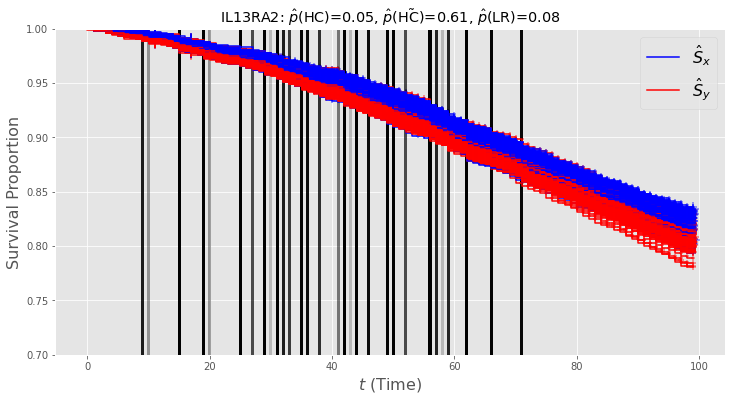

In [301]:
plt.rcParams['figure.figsize'] =  [12, 6]

resi['no_p'] = 0
for r in tqdm(resi.iterrows()):
    gene_name = r[1]['name']
    dfp, dfg = illustrate_survival_curve(df, gene_name, T, stbl=False)
    resi.loc[r[0],'no_p'] = len(dfp)

In [304]:
ls_rep = resi[resi['no_p'] = 2].name.unique()
ls_rep

array(['RCAN1', 'SLCO3A1', 'ST6GALNAC5', 'KANK1', 'ZMAT3', 'SLC8A1',
       'RGS14', 'TMEM38B', 'HIST1H3G', 'SLC5A12', 'CTNNA1', 'EDC3',
       'PLCG2', 'NFIB', 'LRRC41', 'MED17', 'RNF7', 'VAMP4', 'FHL2',
       'ECHDC1', 'PKDREJ', 'UXT', 'FURIN', 'KPNB1', 'HIST1H4B', 'BCLAF1',
       'SCRG1', 'SNAPC5', 'SEC22A', 'SIGMAR1', 'SARDH', 'PREPL',
       'CREB3L1', 'ZNF778', 'HNRNPA3', 'IFNAR2', 'C11orf68', 'RBPJ',
       'CEP76', 'RHOQ', 'FNDC8', 'SEC61A2', 'UCK2', 'R3HCC1', 'DYRK4',
       'DEFB1', 'OR7A5', 'SNAP29', 'TOX4', 'AKR1B1', 'FBXL12', 'ZMYM3',
       'ACP6', 'CD9', 'CNOT4', 'SUPT16H', 'KAZALD1', 'CPT2', 'MTMR1',
       'RAP2A', 'GLG1', 'OPCML', 'BEX4', 'XRCC5', 'STX4', 'RIMS2', 'PMS2',
       'TOMM7', 'PASK', 'ATR', 'CCDC7'], dtype=object)

In [336]:
ls_rep = ['ADSS', 'DCK', 'RCAN1', 'ST6GALNAC5', 'SLC8A1', 'SIGMAR1', 'VAMP4']

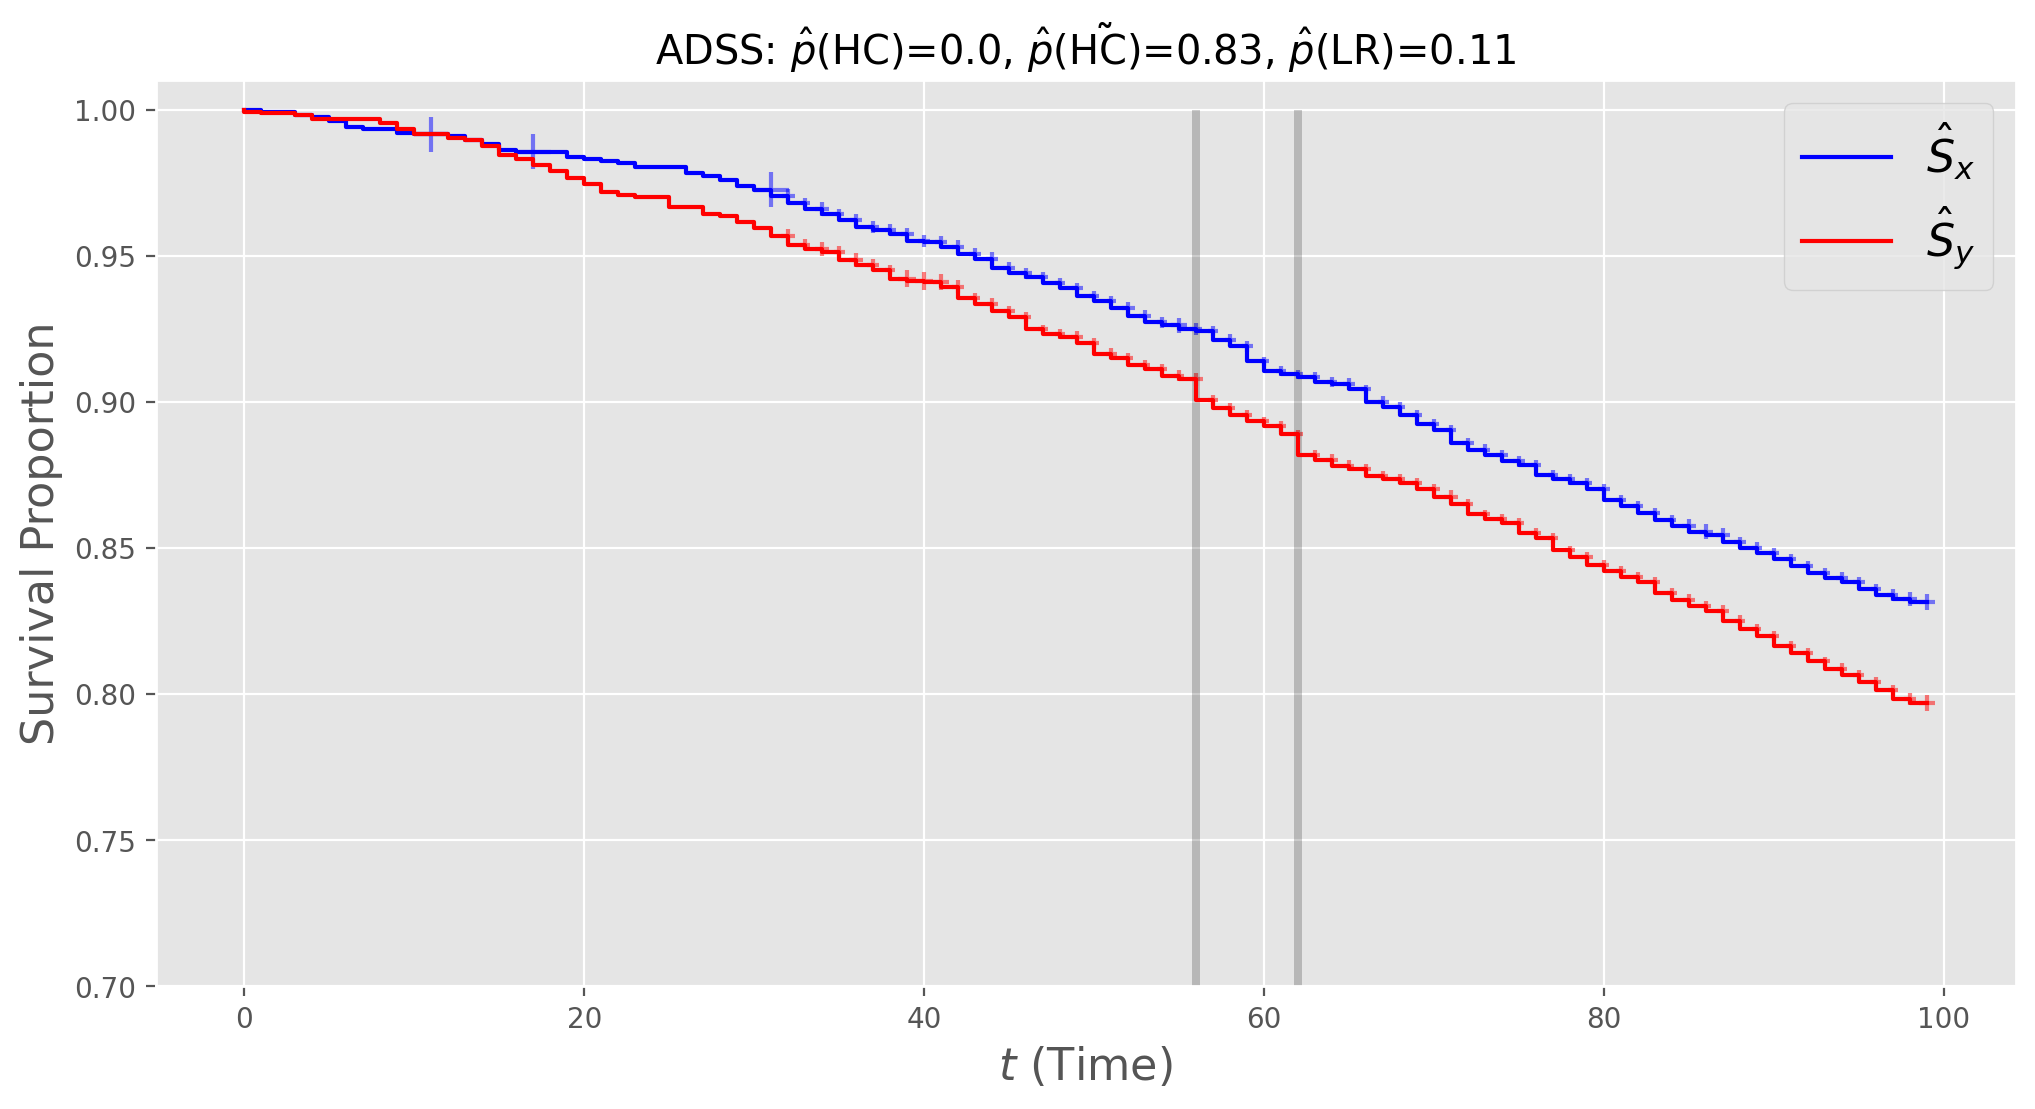

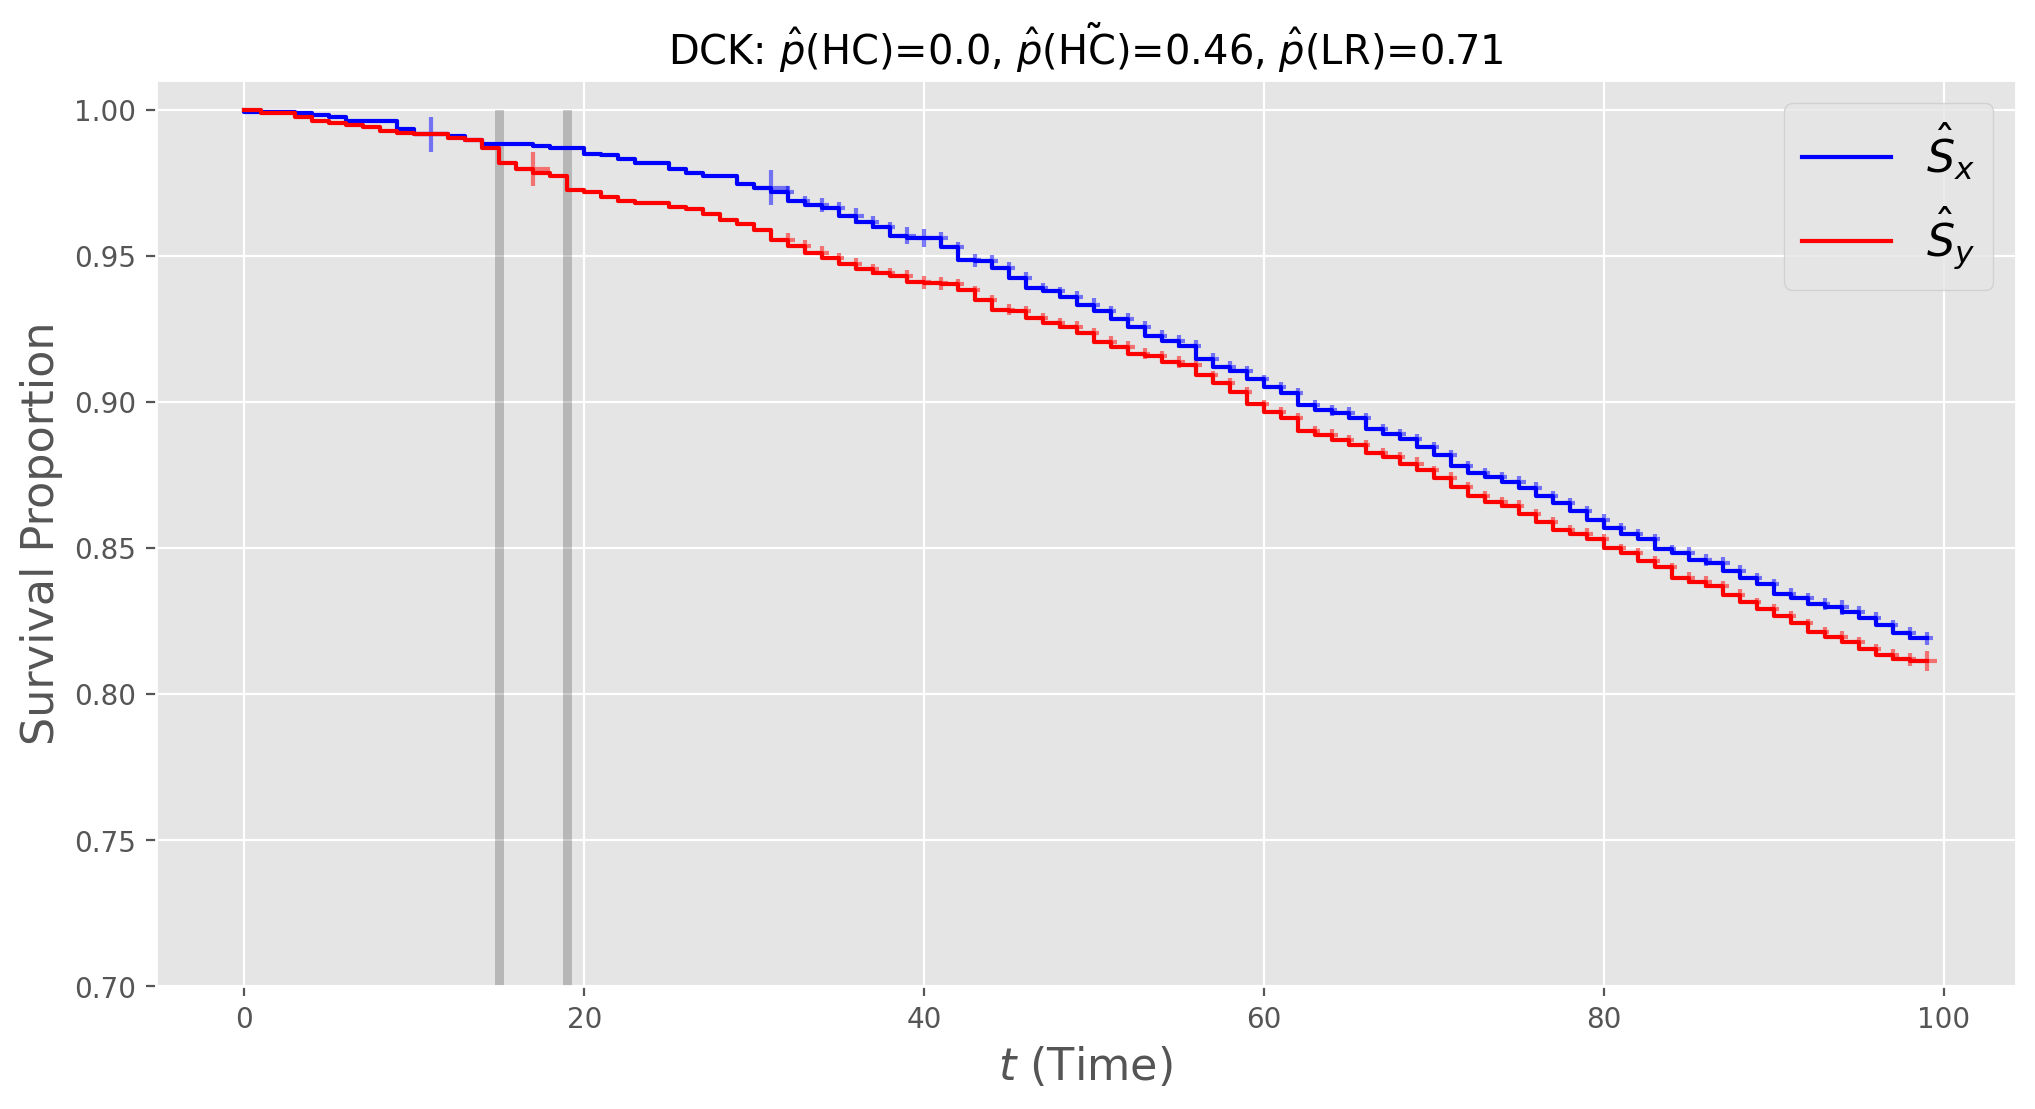

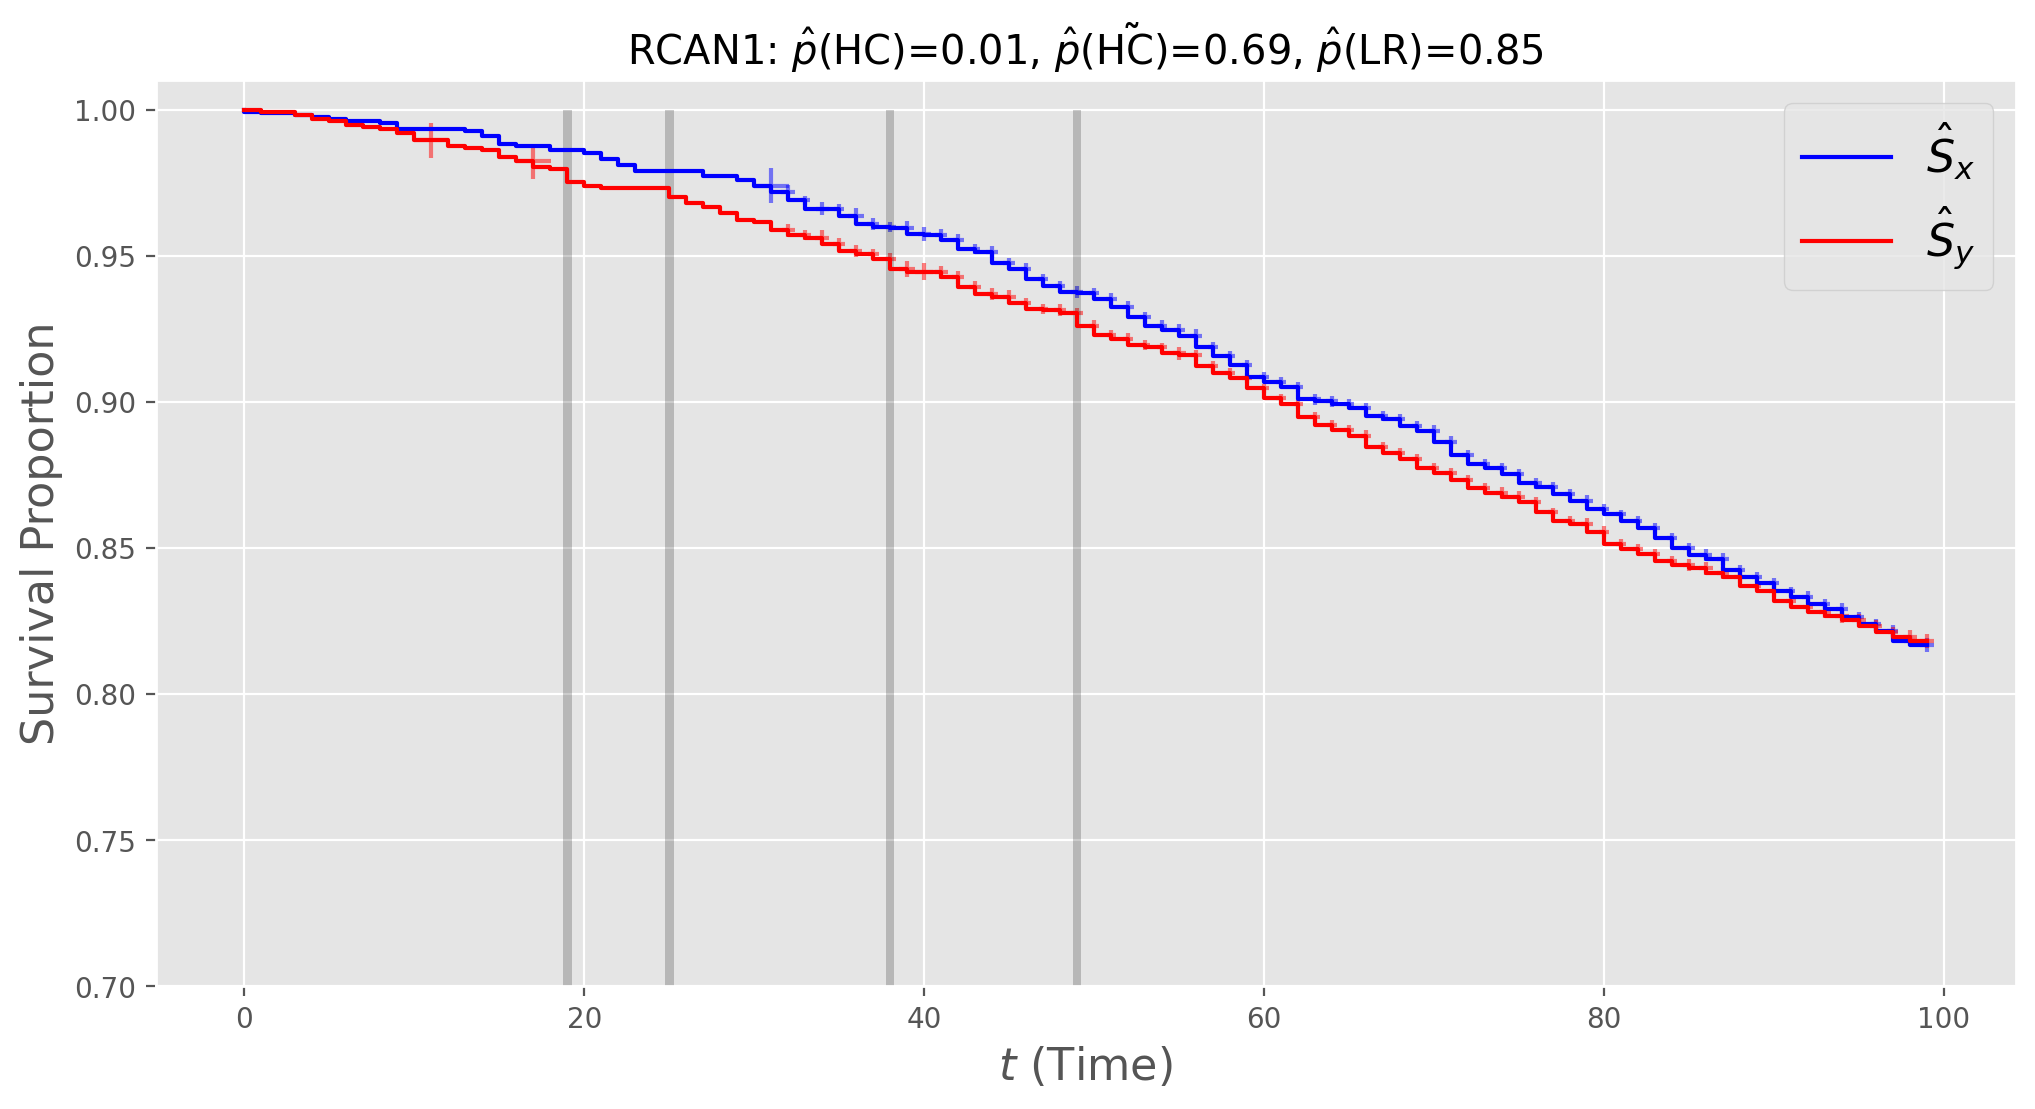

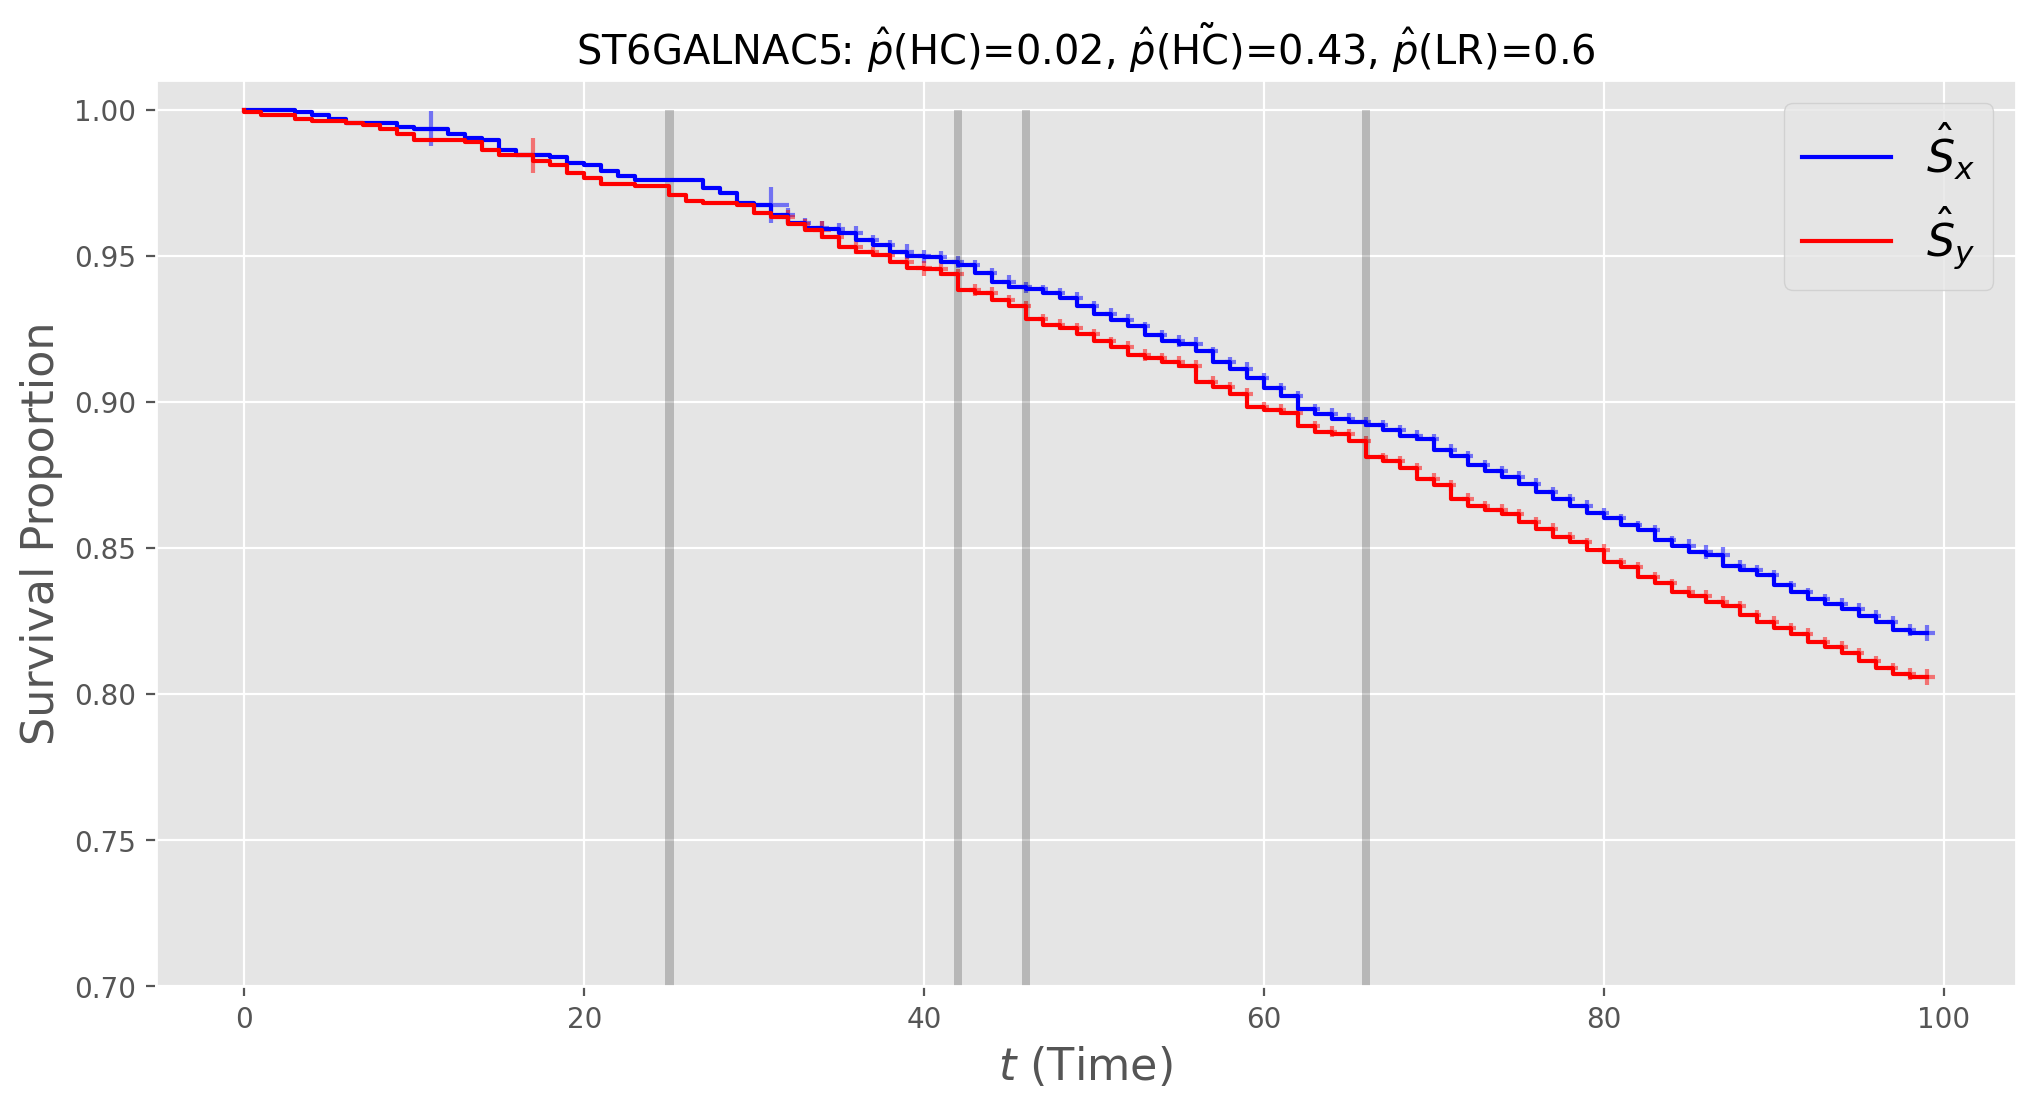

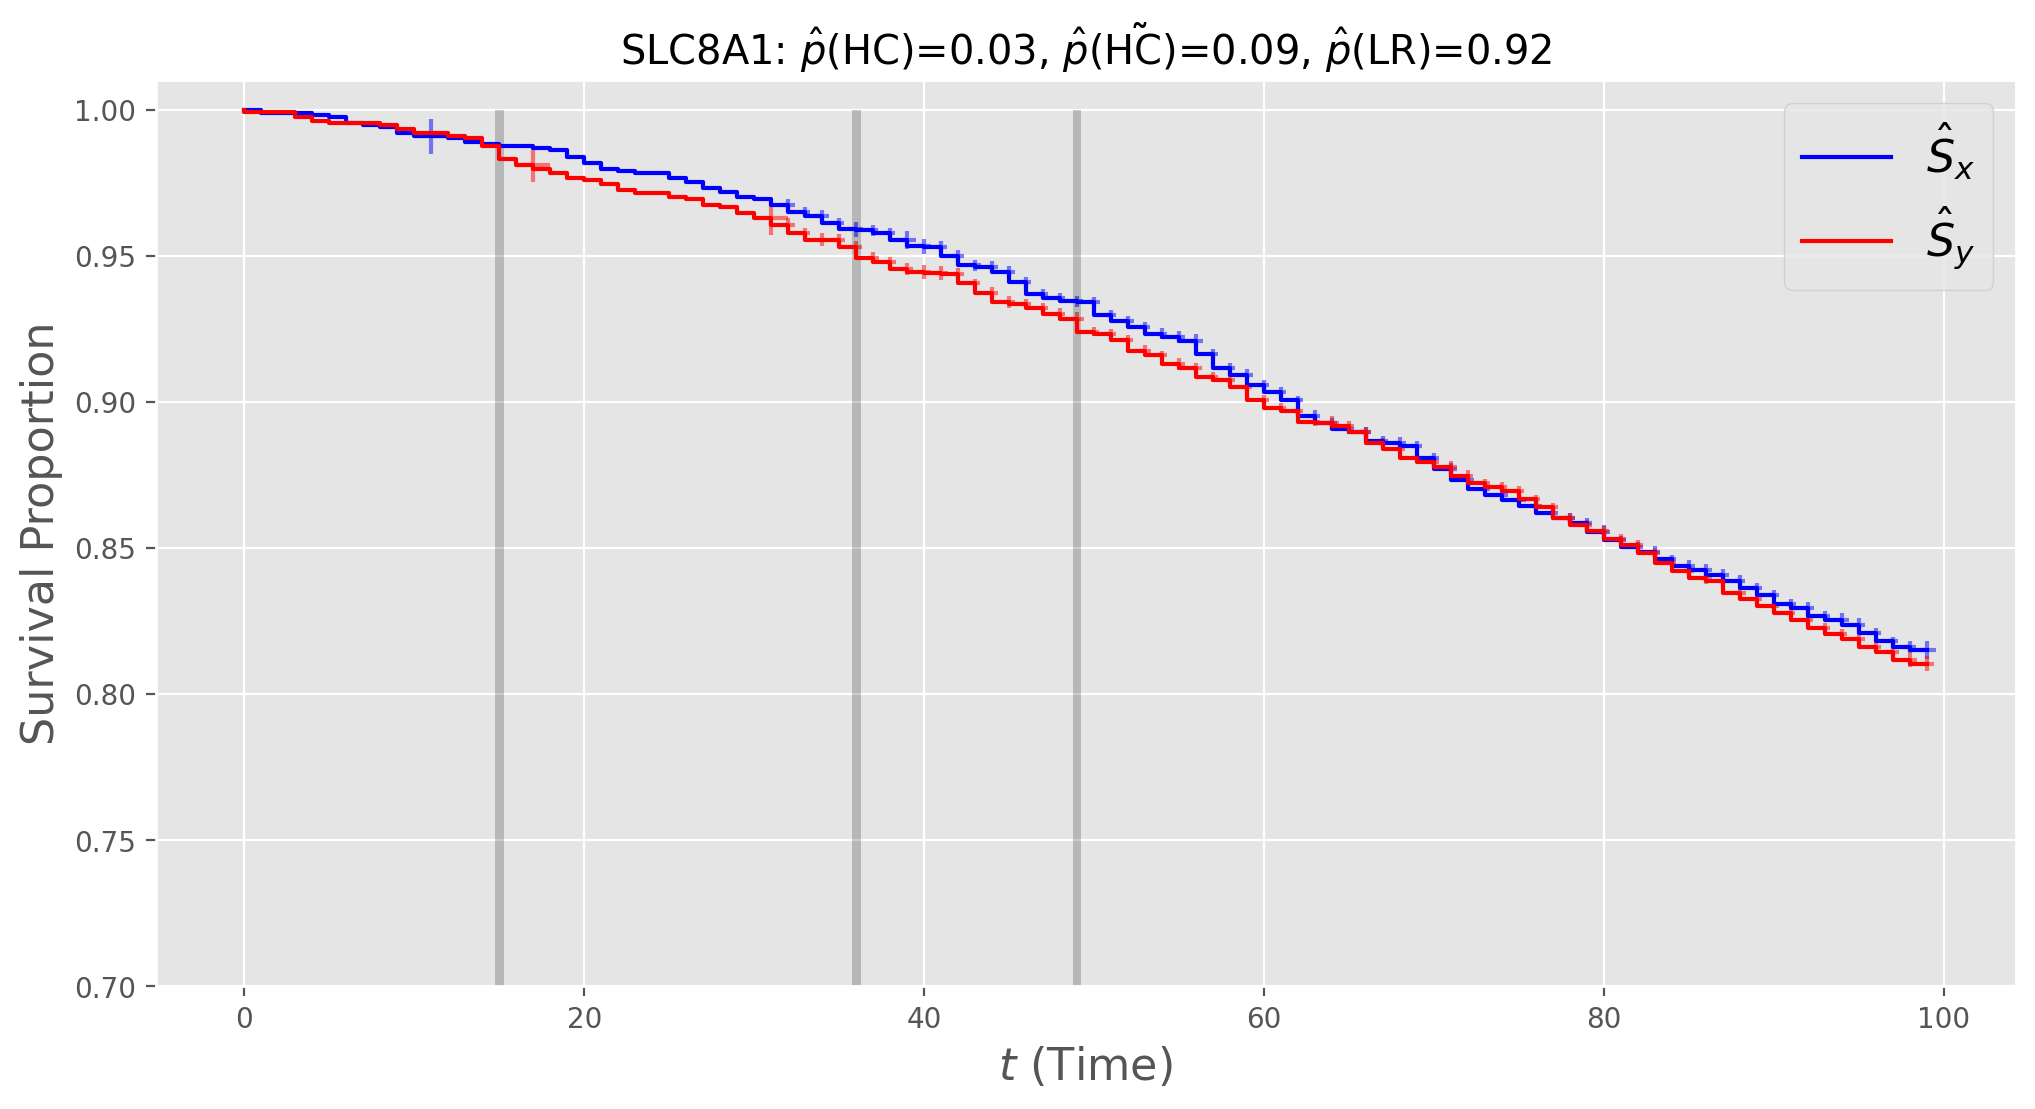

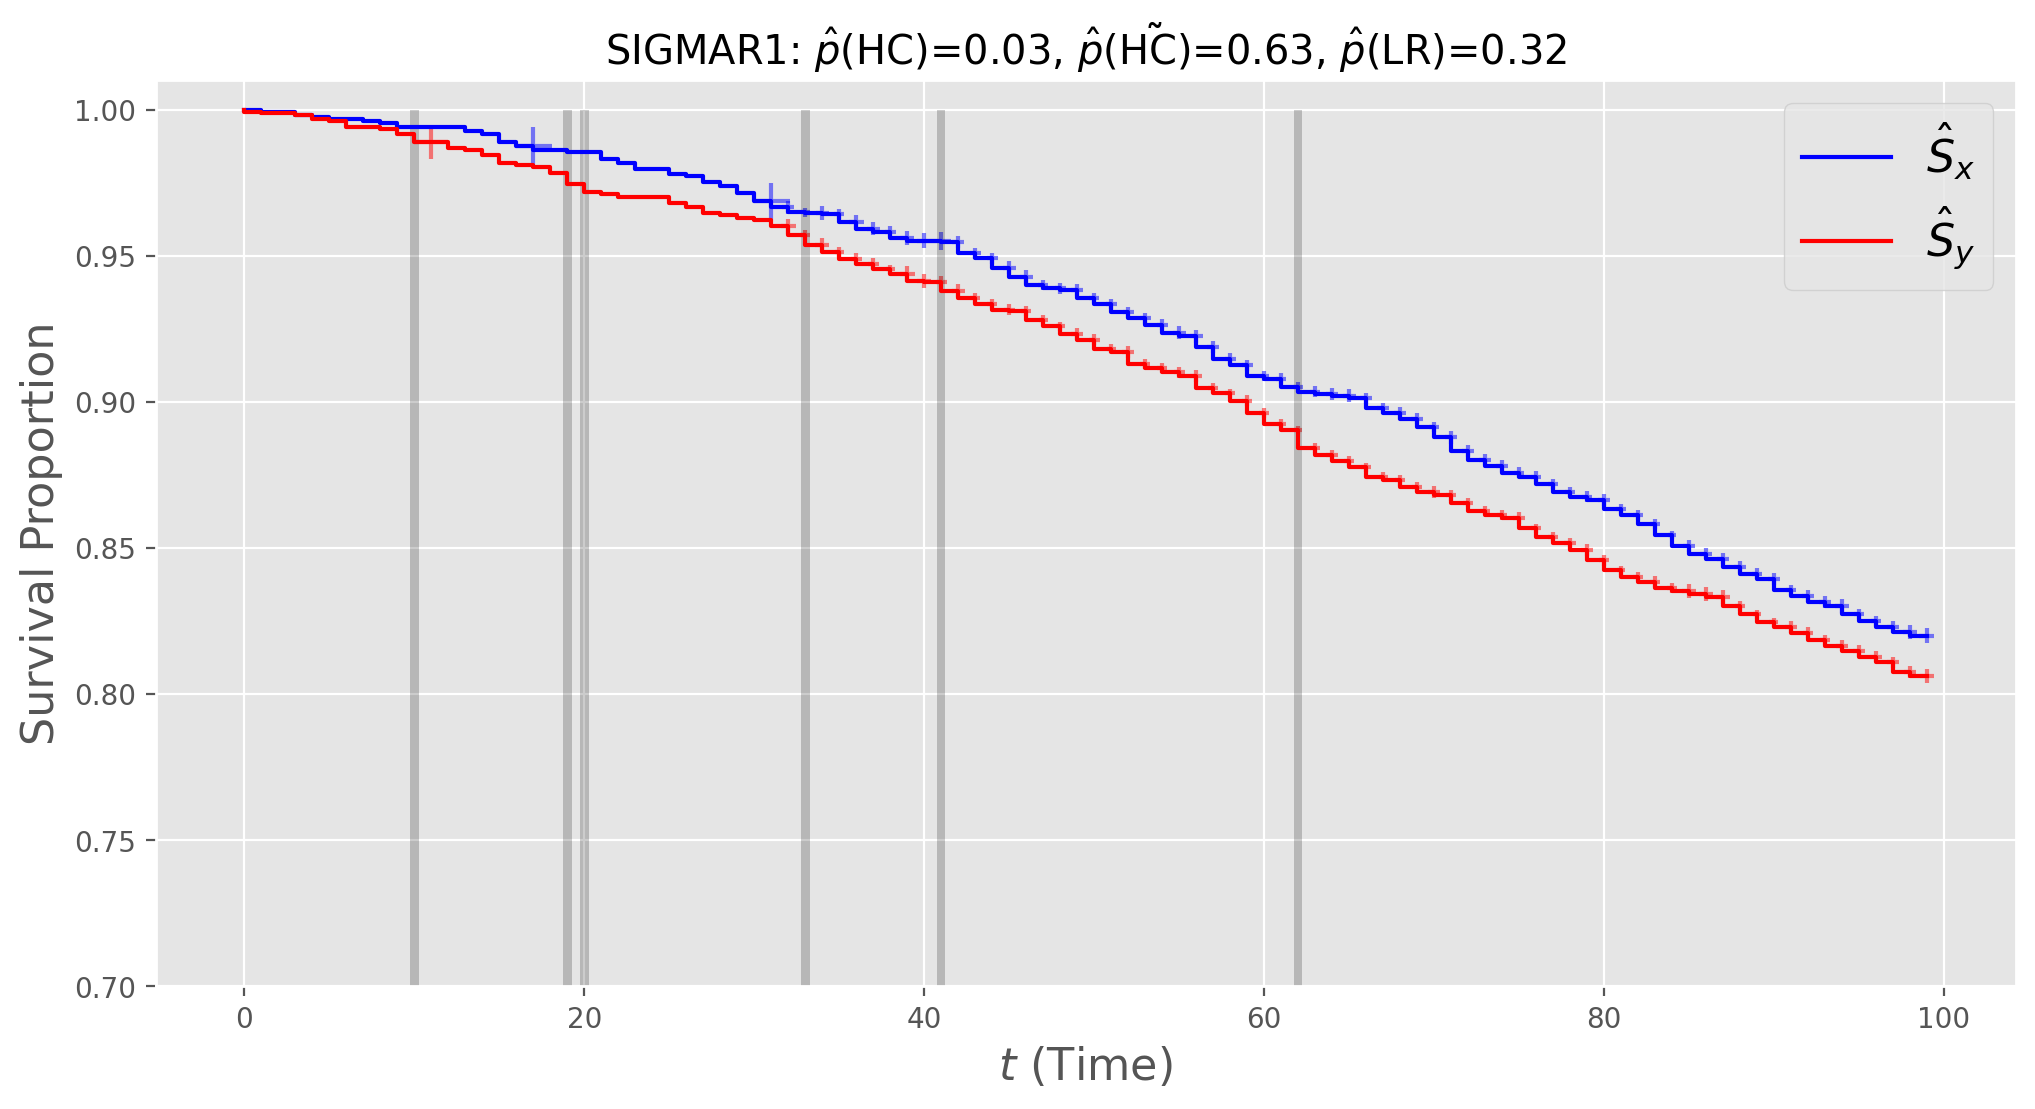

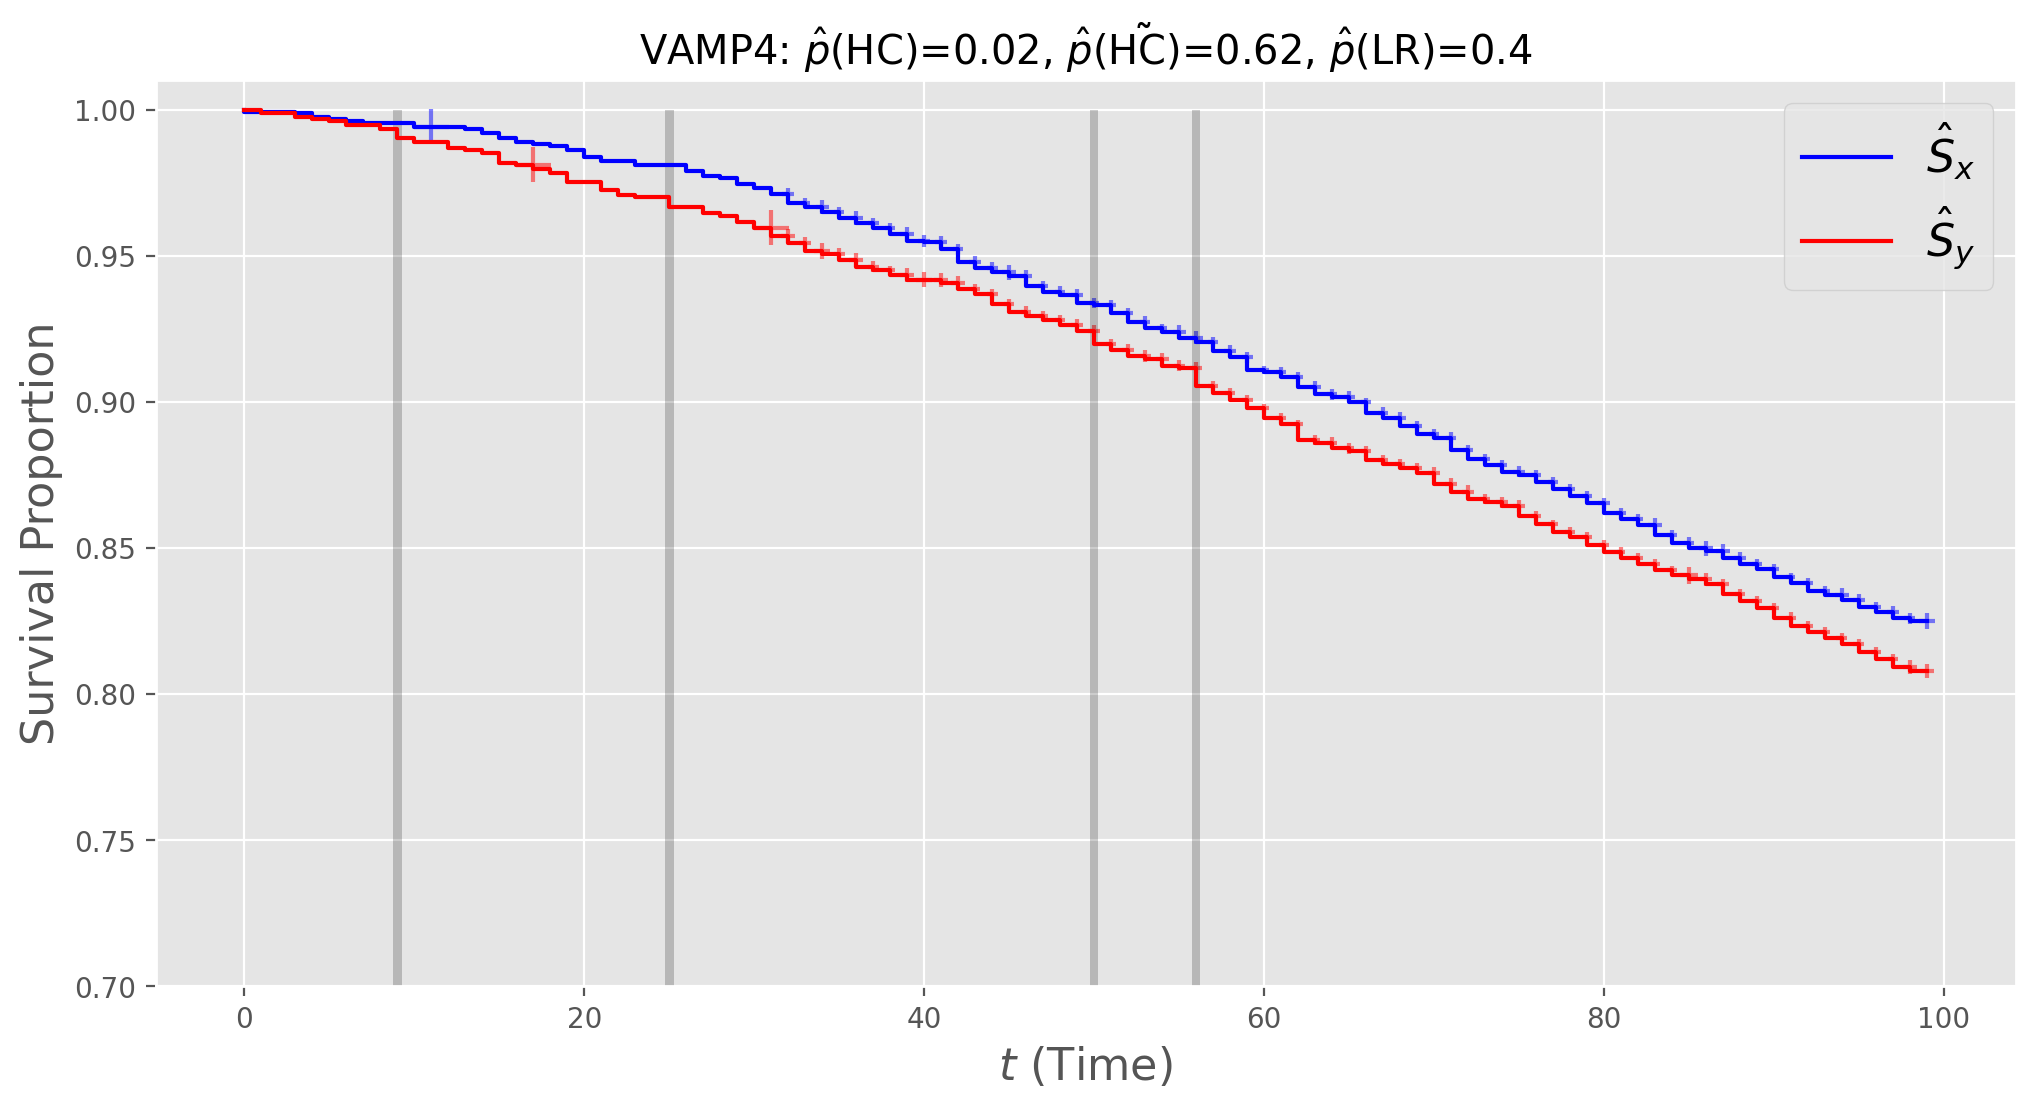

In [337]:
plt.rcParams['figure.figsize'] =  [12, 6]
plt.rcParams["figure.dpi"] = 200

for gene_name in ls_rep:
    df_disp, dfp = illustrate_survival_curve(df, gene_name, T, stbl=True)
    plt.savefig(remote_dir + gene_name + ".png")
    plt.show()

    dfd = df_disp.copy()
    dfd = dfd.iloc[:, :-2]

    for tag in ['pvalue', 'pvalue_rev']:
        dfd[tag] = np.round(dfd[tag],3)

    for tag in ['at-risk X', 'at-risk Y', 'events X', 'events Y']:
        dfd[tag] = dfd[tag].astype(int)

    dfd.index.name = 'time'

    rm_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/csv/"
    dfd.filter(['at-risk X', 'at-risk Y', 'events X', 'events Y', 'pvalue', 'pvalue_rev'])\
        .to_csv(rm_dir + f'{gene_name}.csv')


In [248]:
M = 1000
T = 100
df0g = pd.read_csv(f'results/SCNAB_null_{stbl}_T{T}_M{M}.csv')
gstats = df0g.groupby('name').agg([q95, std_95])


/usr/local/lib/python3.8/site-packages/scipy/stats/_mstats_extras.py:270: RuntimeWarning: invalid value encountered in sqrt
  mj[i] = np.sqrt(C2 - C1**2)


In [267]:
print("Saving SCNAB results...")
rm_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/csv/"
path = rm_dir + "results_SCNAB.csv"


def prepare_for_display(resi):
    flip_idc = resi['hc_greater'] < resi['hc_greater_rev']
    resi['flip'] = '$<$ med'
    resi.loc[flip_idc, 'flip'] = '$>$ med'
    resi['hc'] = np.maximum(resi['hc_greater'], resi['hc_greater_rev'])
    resi['log_rank'] = np.maximum(resi['log_rank_greater'], resi['log_rank_greater_rev'])
    rr = resi.reset_index().filter(['name', 'hc', 'hc_pval', 'log_rank_pval', 'log_rank', 'flip'])

    return rr[rr['log_rank'] > 0.05]

df_disp = prepare_for_display(resi).set_index('name').head(10)
df_disp.to_csv(path)
print(f"saved to {path}")


Saving SCNAB results...
saved to /Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/csv/results_SCNAB.csv


In [269]:
df_disp

,hc,hc_pval,log_rank_pval,log_rank,flip
name,,,,,
DCK,1.435281,0.000200,0.709338,0.353713,$<$ med
ADSS,1.483096,0.000165,0.110271,1.522972,$<$ med
EIF2B4,1.081176,0.003034,0.686693,0.382852,$<$ med
SCAP,1.121329,0.002211,0.407235,0.787018,$<$ med
TPM1,1.011221,0.004606,0.829323,0.204837,$>$ med
SIPA1,0.993125,0.005178,0.921707,0.093377,$<$ med
OSGEP,1.162772,0.001582,0.262330,1.068602,$<$ med
SRP9,0.978785,0.005600,0.914490,0.102412,$<$ med
TMCO1,1.012705,0.004670,0.757486,0.293578,$<$ med


In [ ]:
df_disp, dfp = illustrate_survival_curve(df, gene_name, T)
plt.savefig(remote_dir + gene_name + ".png")
plt.show()

dfd = df_disp.copy()
dfd = dfd.iloc[:, :-2]

for tag in ['pvalue', 'pvalue_rev']:
    dfd[tag] = np.round(dfd[tag],3)

for tag in ['at-risk X', 'at-risk Y', 'events X', 'events Y']:
    dfd[tag] = dfd[tag].astype(int)

dfd.index.name = 'time'
    
rm_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/csv/"
dfd.to_csv(rm_dir + f'{gene_name}.csv')
